In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import log_loss
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [15]:
df_train = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')
df_train

,game_id,Date,VH,Team,Final,ML,ML_pct,Open Total,Close Total,Open Spread,...,W/L_H_fav,W/L_V_fav,W/L_H_dog,W/L_V_dog,ATS_H_fav,ATS_V_fav,ATS_H_dog,ATS_V_dog,Push,W/L_bool
0,1324,2020-10-11,N,LALakers,106,-250.0,0.71,NaN,NaN,-5.0,...,0,0,0,0,0,0,0,0,0,1
1,1324,2020-10-11,N,Miami,93,210.0,0.32,216.5,215.0,5.0,...,0,0,0,0,0,0,0,0,0,0
2,1325,2020-10-09,N,LALakers,108,-340.0,0.77,NaN,NaN,-7.5,...,0,0,0,0,0,0,0,0,0,0
3,1325,2020-10-09,N,Miami,111,280.0,0.26,217.0,215.0,7.5,...,0,0,1,1,0,0,0,0,0,1
4,1326,2020-10-06,N,LALakers,102,-330.0,0.77,NaN,NaN,-7.5,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33323,17985,2007-10-30,H,LALakers,93,190.0,0.34,191.0,199.0,2.5,...,0,0,0,0,0,0,1,0,0,0
33324,17986,2007-10-30,H,GoldenState,96,-120.0,0.55,NaN,NaN,-3.0,...,0,0,0,0,0,0,0,0,0,0
33325,17986,2007-10-30,V,Utah,117,100.0,0.50,214.5,212.0,3.0,...,0,0,0,1,0,0,0,0,0,1
33326,17987,2007-10-30,H,SanAntonio,106,-1400.0,0.93,NaN,NaN,-12.5,...,1,0,0,0,0,0,0,0,0,1


In [16]:
df_train['Payout'] = df_train.groupby('game_id')['ML'].transform(lambda x: (100 / abs(x.iloc[0])) * 100)
df_train.loc[df_train.groupby('game_id').cumcount() > 0, 'Payout'] = None

df_train['Payout'] = pd.to_numeric(df_train['Payout'], errors='coerce')

In [17]:
# # Replace NaN values in the second row with corresponding payout values
second_row_mask = df_train.groupby('game_id').cumcount() == 1
df_train.loc[second_row_mask, 'Payout'] = df_train.loc[second_row_mask, 'ML'].abs()

In [18]:
df_train['Payout'] = df_train['Payout'].apply(lambda x: math.ceil(x * 100) / 100 if not math.isnan(x) else x)

In [20]:
df_train.to_csv('../nss_capstone/df_train_07_20.csv')

In [19]:
df_train

,game_id,Date,VH,Team,Final,ML,ML_pct,Open Total,Close Total,Open Spread,...,W/L_V_fav,W/L_H_dog,W/L_V_dog,ATS_H_fav,ATS_V_fav,ATS_H_dog,ATS_V_dog,Push,W/L_bool,Payout
0,1324,2020-10-11,N,LALakers,106,-250.0,0.71,NaN,NaN,-5.0,...,0,0,0,0,0,0,0,0,1,40.00
1,1324,2020-10-11,N,Miami,93,210.0,0.32,216.5,215.0,5.0,...,0,0,0,0,0,0,0,0,0,210.00
2,1325,2020-10-09,N,LALakers,108,-340.0,0.77,NaN,NaN,-7.5,...,0,0,0,0,0,0,0,0,0,29.42
3,1325,2020-10-09,N,Miami,111,280.0,0.26,217.0,215.0,7.5,...,0,1,1,0,0,0,0,0,1,280.00
4,1326,2020-10-06,N,LALakers,102,-330.0,0.77,NaN,NaN,-7.5,...,0,0,0,0,0,0,0,0,1,30.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33323,17985,2007-10-30,H,LALakers,93,190.0,0.34,191.0,199.0,2.5,...,0,0,0,0,0,1,0,0,0,190.00
33324,17986,2007-10-30,H,GoldenState,96,-120.0,0.55,NaN,NaN,-3.0,...,0,0,0,0,0,0,0,0,0,83.34
33325,17986,2007-10-30,V,Utah,117,100.0,0.50,214.5,212.0,3.0,...,0,0,1,0,0,0,0,0,1,100.00
33326,17987,2007-10-30,H,SanAntonio,106,-1400.0,0.93,NaN,NaN,-12.5,...,0,0,0,0,0,0,0,0,1,7.15


In [145]:
#payout.to_csv('../nss_capstone/payout.csv')

                        *******'ML'***********

In [36]:
# 10 folds

payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 10
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [38]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101)).mean().sort_values()

0.000   -2763.2180
0.001   -2118.1915
0.002   -1906.3445
0.003   -1491.3770
0.004   -1373.9285
           ...    
0.029     269.3420
0.026     329.7940
0.025     339.6715
0.023     357.0735
0.024     377.0735
Length: 101, dtype: float64

In [39]:
ML_pct_folds_10 = pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))

In [40]:
ML_pct_folds_10[0.033].mean()

204.942

In [41]:
# Kfold (10 folds) ML_pct plots

desired_num_folds = 10

# Create subplots with shared x-axis
fig = make_subplots(rows=desired_num_folds, cols=1, shared_xaxes=True)

# Define fold labels for the dropdown menu, limited to the desired number of folds
fold_labels = [f"Fold {i+1}" for i in range(desired_num_folds)]

# Iterate over each fold up to the desired number and add a trace to the corresponding subplot
for fold, profit_fold in enumerate(profits[:desired_num_folds]):
    # Create a trace for the current fold
    trace = go.Scatter(
        x=np.linspace(start=0.1, stop=0.5, num=101),
        y=profit_fold,
        mode='lines',
        name=f"Fold {fold+1}"
    )

    # Add the trace to the subplot
    fig.add_trace(trace, row=fold+1, col=1)

# Update layout and add a dropdown menu limited to the desired number of folds
fig.update_layout(
    title="K-fold Results with 10 Folds",
    xaxis=dict(title=""),
    yaxis=dict(title=""),
    updatemenus=[
        dict(
            active=0,
            buttons=list([ dict(label="Show All Folds", method="update", args=[{"visible": [True] * len(fig.data)}]),
                *[
                dict(label=fold_label, method="update", args=[{"visible": [fold == i for i in range(desired_num_folds)]}])
                for fold_label, fold in zip(fold_labels, range(desired_num_folds))
            ]]),
            x=1.1,  # Set the x position of the dropdown menu to the right of the plot
            y=1.15,  # Set the y position of the dropdown menu above the plot
            xanchor='right',  # Anchor the x position to the right
            yanchor='top'  # Anchor the y position to the top
                          )
    ],
    width=800,  # Set the width of the plot
    height=650  # Set the height of the plot
    )


# Move the legend to the top right corner
fig.update_layout(legend=dict(x=1, y=1, xanchor='left', yanchor='top'))

# Show the plot
fig.show()

In [42]:
# 20 folds

payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 20
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [43]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101)).mean().sort_values()

0.000   -2763.2180
0.001   -2118.1915
0.002   -1906.3445
0.003   -1491.3770
0.004   -1373.9285
           ...    
0.029     269.3420
0.026     329.7940
0.025     339.6715
0.023     357.0735
0.024     377.0735
Length: 101, dtype: float64

In [44]:
ML_pct_folds_20 = pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))

In [45]:
ML_pct_folds_20[0.049].mean()

-64.8375

In [46]:
# Kfold (20 folds) ML_pct plots

desired_num_folds = 20

# Create subplots with shared x-axis
fig = make_subplots(rows=desired_num_folds, cols=1, shared_xaxes=True)

# Define fold labels for the dropdown menu, limited to the desired number of folds
fold_labels = [f"Fold {i+1}" for i in range(desired_num_folds)]

# Iterate over each fold up to the desired number and add a trace to the corresponding subplot
for fold, profit_fold in enumerate(profits[:desired_num_folds]):
    # Create a trace for the current fold
    trace = go.Scatter(
        x=np.linspace(start=0.1, stop=0.5, num=101),
        y=profit_fold,
        mode='lines',
        name=f"Fold {fold+1}"
    )

    # Add the trace to the subplot
    fig.add_trace(trace, row=fold+1, col=1)

# Update layout and add a dropdown menu limited to the desired number of folds
fig.update_layout(
    title="K-fold Results with 20 Folds",
    xaxis=dict(title=""),
    yaxis=dict(title=""),
    updatemenus=[
        dict(
            active=0,
            buttons=list([ dict(label="Show All Folds", method="update", args=[{"visible": [True] * len(fig.data)}]),
                *[
                dict(label=fold_label, method="update", args=[{"visible": [fold == i for i in range(desired_num_folds)]}])
                for fold_label, fold in zip(fold_labels, range(desired_num_folds))
            ]]),
            x=1.1,  # Set the x position of the dropdown menu to the right of the plot
            y=1.15,  # Set the y position of the dropdown menu above the plot
            xanchor='right',  # Anchor the x position to the right
            yanchor='top'  # Anchor the y position to the top
                          )
    ],
    width=900,  # Set the width of the plot
    height= 1050  # Set the height of the plot
    )


# Move the legend to the top right corner
fig.update_layout(legend=dict(x=1, y=1, xanchor='left', yanchor='top'))

# Show the plot
fig.show()

In [47]:
# 30 folds

payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 30
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [48]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101)).mean().sort_values()

0.000   -1452.768000
0.001   -1218.860333
0.002   -1155.156000
0.003   -1126.295667
0.004    -879.266000
            ...     
0.025     216.064333
0.024     232.897667
0.023     233.131000
0.022     236.632333
0.026     241.064333
Length: 101, dtype: float64

In [76]:
ML_pct_folds_30 = pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101)).mean().sort_values()#.idxmax()

In [77]:
ML_pct_folds_30#[0.033].sum()

0.000   -637.068000
0.001   -449.121000
0.002   -371.509000
0.003   -294.713667
0.004   -260.685333
            ...    
0.024    506.426000
0.023    508.426000
0.020    509.058667
0.022    535.692667
0.021    550.692667
Length: 101, dtype: float64

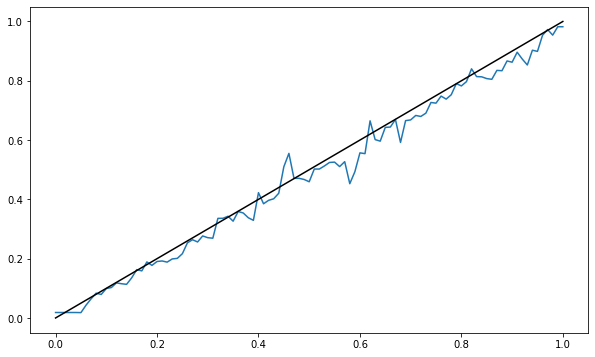

In [54]:


# plt.figure(figsize = (10,6))

# calibrated_classifier.predict_proba(np.linspace(start = 0, stop = 1, num = 101).reshape (-1,1))[:, 1]
# plt.plot(
# np.linspace(start = 0, stop = 1, num = 101),
# calibrated_classifier.predict_proba(np.linspace(start = 0, stop = 1, num = 101).reshape (-1,1))[:, 1])


# calibrated_classifier.predict_proba(np.linspace(start = 0, stop = 1, num = 101).reshape (-1,1))[:, 1]
# plt.plot(
# np.linspace(start = 0, stop = 1, num = 101),
# np.linspace(start = 0, stop = 1, num = 101), color = 'black')



In [67]:
predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

percentage_differences = predicted_probabilities - closing_moneyline_odds    
selected_bets = percentage_differences >= threshold

payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
results = y_test.reset_index(drop = True) 

bets_won = selected_bets * results * payouts
bets_lost = selected_bets * (1-results) * -wager
profit = bets_won.sum() + bets_lost.sum()
# wager = 100  # Set the wager amount to $100
# profit = np.sum(selected_bets * (wager * closing_moneyline_odds - wager))
# profits.append(profit)

# replaced_wagers.append(np.sum(selected_bets))
# bets_won.append(np.sum(selected_bets * y_test))  # Sum of bets won (replaced wagers)
# bets_lost.append(np.sum(selected_bets * (1 - y_test))) 

In [69]:
profit

1750.2099999999991

In [160]:
selected_bets.sum()*100

300

In [61]:
y_test.reset_index(drop = True) * payouts

0        64.52
1         0.00
2        35.72
3         0.00
4         0.00
         ...  
7189      0.00
7190      0.00
7191    105.00
7192      0.00
7193    100.00
Length: 7194, dtype: float64

                        ***********ML, Open/Close Spread***********

In [51]:
# 10 Folds, 3 features

payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML', 'Open Spread', 'Close Spread'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 10
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [52]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))#.mean().sort_values()

,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100
0,-9365.50,-8767.99,-6922.73,-4505.97,-2009.36,-1329.84,-1654.55,-732.89,-273.45,-1031.91,...,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00,-400.00
1,-11705.65,-11145.65,-8126.90,-7425.83,-7666.01,-7349.72,-6026.56,-5880.37,-4997.59,-6681.59,...,-500.00,-500.00,-500.00,-500.00,-500.00,-500.00,-400.00,-400.00,-400.00,-400.00
2,-2224.20,-3094.20,-3561.19,-2496.19,-2200.71,-2843.51,-3397.21,-2982.51,-2806.97,-2831.97,...,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00
3,-2859.73,-2452.05,-1873.84,-1557.84,-825.21,-946.63,-2837.40,-1701.81,-57.29,513.29,...,-70.00,-70.00,-70.00,30.00,30.00,30.00,30.00,130.00,130.00,-300.00
4,-8031.26,-6957.26,-5935.97,-5442.74,-5147.74,-4621.80,-4649.53,-4016.66,-3086.66,-1163.66,...,425.00,425.00,425.00,425.00,425.00,425.00,425.00,425.00,425.00,425.00
5,-1979.63,-1614.63,-2923.78,-2082.05,-1486.88,-1206.37,-403.37,-353.83,-704.09,-1478.53,...,-102.91,-102.91,-2.91,-2.91,-2.91,-2.91,-2.91,-2.91,-2.91,-2.91
6,-2838.22,-2239.91,-2635.95,-1487.34,-3839.54,-4144.54,-3308.07,-1894.68,-1374.16,-414.16,...,1383.00,1383.00,1383.00,1383.00,1383.00,1383.00,1383.00,1383.00,1483.00,1483.00
7,3786.09,3953.58,3065.05,2115.65,1544.59,1324.59,-1221.41,-1232.16,-1498.94,-1301.42,...,225.00,225.00,225.00,225.00,225.00,225.00,225.00,225.00,225.00,225.00
8,-1461.19,-961.43,-860.45,135.25,-998.91,-629.74,-145.07,-261.76,18.24,472.39,...,350.00,350.00,350.00,350.00,350.00,350.00,450.00,450.00,450.00,450.00
9,-2777.03,-1612.54,-1963.81,-2103.81,-3549.77,-1753.85,-1176.59,-836.59,-2734.96,-2872.00,...,470.00,470.00,470.00,470.00,470.00,470.00,0.00,0.00,0.00,0.00


In [72]:
ML_etc_folds_10 = pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101)).mean().sort_values()#.idxmax()

In [73]:
ML_etc_folds_10#[0.033].sum()

0.000   -637.068000
0.001   -449.121000
0.002   -371.509000
0.003   -294.713667
0.004   -260.685333
            ...    
0.024    506.426000
0.023    508.426000
0.020    509.058667
0.022    535.692667
0.021    550.692667
Length: 101, dtype: float64

In [55]:
# Kfold (10 folds) 'ML_pct', 'Open Spread', 'Close Spread', 'Open Total', 'Close Total'

desired_num_folds = 10

# Create subplots with shared x-axis
fig = make_subplots(rows=desired_num_folds, cols=1, shared_xaxes=True)

# Define fold labels for the dropdown menu, limited to the desired number of folds
fold_labels = [f"Fold {i+1}" for i in range(desired_num_folds)]

# Iterate over each fold up to the desired number and add a trace to the corresponding subplot
for fold, profit_fold in enumerate(profits[:desired_num_folds]):
    # Create a trace for the current fold
    trace = go.Scatter(
        x=np.linspace(start=0.1, stop=0.5, num=101),
        y=profit_fold,
        mode='lines',
        name=f"Fold {fold+1}"
    )

    # Add the trace to the subplot
    fig.add_trace(trace, row=fold+1, col=1)

# Update layout and add a dropdown menu limited to the desired number of folds
fig.update_layout(
    title='K-fold Results with 10 Folds (3 features)',
    xaxis=dict(title=""),
    yaxis=dict(title=""),
    updatemenus=[
        dict(
            active=0,
            buttons=list([ dict(label="Show All Folds", method="update", args=[{"visible": [True] * len(fig.data)}]),
                *[
                dict(label=fold_label, method="update", args=[{"visible": [fold == i for i in range(desired_num_folds)]}])
                for fold_label, fold in zip(fold_labels, range(desired_num_folds))
            ]]),
            x=1.1,  # Set the x position of the dropdown menu to the right of the plot
            y=1.15,  # Set the y position of the dropdown menu above the plot
            xanchor='right',  # Anchor the x position to the right
            yanchor='top'  # Anchor the y position to the top
                          )
    ],
    width=800,  # Set the width of the plot
    height= 1000  # Set the height of the plot
    )


# Move the legend to the top right corner
fig.update_layout(legend=dict(x=1, y=1, xanchor='left', yanchor='top'))

# Show the plot
fig.show()

In [56]:
# 20 folds, 3 features

payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML', 'Open Spread', 'Close Spread'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 20
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [57]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101))#.mean().sort_values()

,0.000,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,...,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099,0.100
0,-8059.08,-7159.08,-6264.08,-6283.71,-5950.94,-5659.15,-4886.93,-4657.70,-3982.70,-4594.44,...,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00
1,-6902.85,-6402.85,-6102.85,-5360.71,-4098.45,-3244.70,-3134.68,-2719.68,-2714.68,-3369.68,...,-300.00,-300.00,-300.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00
2,-1399.81,-881.75,-1451.75,-1550.46,-804.92,-879.92,-1294.92,-614.92,-1523.62,-1615.08,...,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00
3,26.00,620.00,1030.00,1914.76,1042.52,516.68,1316.68,1051.68,1367.22,1336.45,...,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00
4,-2819.54,-2764.00,-2630.37,-3125.37,-2974.08,-3431.48,-4032.55,-3922.55,-3917.55,-3862.55,...,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00
5,-657.25,-392.73,228.30,-1371.70,-2221.40,-2758.40,-1928.40,-1198.40,-1296.74,-823.78,...,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00,-100.00
6,-948.59,-944.99,-1239.99,-2119.99,-1452.99,-1287.99,-87.99,965.78,1467.25,2067.25,...,1583.00,1583.00,1583.00,1583.00,1583.00,1583.00,1583.00,1583.00,1583.00,1583.00
7,-2246.52,-1860.05,-747.05,-2006.41,-1697.78,-2033.78,-1361.18,-1366.18,-766.18,-919.96,...,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00,-300.00
8,-3666.50,-4286.73,-3814.79,-3434.81,-2738.59,-2362.40,-2547.40,-2347.40,-2307.40,-2151.09,...,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00
9,-3028.61,-3989.73,-3789.13,-2866.13,-2000.66,-795.63,-195.63,489.37,-495.63,279.37,...,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00,470.00


In [69]:
ML_etc_folds_20 = pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101)).mean().sort_values()#.idxmax()

In [70]:
ML_etc_folds_20

0.000   -637.068000
0.001   -449.121000
0.002   -371.509000
0.003   -294.713667
0.004   -260.685333
            ...    
0.024    506.426000
0.023    508.426000
0.020    509.058667
0.022    535.692667
0.021    550.692667
Length: 101, dtype: float64

In [60]:
ML_etc_folds_20[0.033].sum()

4172.42

In [61]:
# 20 folds, 3 features 

desired_num_folds = 20

# Create subplots with shared x-axis
fig = make_subplots(rows=desired_num_folds, cols=1, shared_xaxes=True)

# Define fold labels for the dropdown menu, limited to the desired number of folds
fold_labels = [f"Fold {i+1}" for i in range(desired_num_folds)]

# Iterate over each fold up to the desired number and add a trace to the corresponding subplot
for fold, profit_fold in enumerate(profits[:desired_num_folds]):
    # Create a trace for the current fold
    trace = go.Scatter(
        x=np.linspace(start=0.1, stop=0.5, num=101),
        y=profit_fold,
        mode='lines',
        name=f"Fold {fold+1}"
    )

    # Add the trace to the subplot
    fig.add_trace(trace, row=fold+1, col=1)

# Update layout and add a dropdown menu limited to the desired number of folds
fig.update_layout(
    title='K-fold Results with 20 Folds (5 features)',
    xaxis=dict(title=""),
    yaxis=dict(title=""),
    updatemenus=[
        dict(
            active=0,
            buttons=list([ dict(label="Show All Folds", method="update", args=[{"visible": [True] * len(fig.data)}]),
                *[
                dict(label=fold_label, method="update", args=[{"visible": [fold == i for i in range(desired_num_folds)]}])
                for fold_label, fold in zip(fold_labels, range(desired_num_folds))
            ]]),
            x=1.1,  # Set the x position of the dropdown menu to the right of the plot
            y=1.15,  # Set the y position of the dropdown menu above the plot
            xanchor='right',  # Anchor the x position to the right
            yanchor='top'  # Anchor the y position to the top
                          )
    ],
    width= 900,  # Set the width of the plot
    height= 1050  # Set the height of the plot
    )


# Move the legend to the top right corner
fig.update_layout(legend=dict(x=1, y=1, xanchor='left', yanchor='top'))

# Show the plot
fig.show()

In [62]:
# 30 folds, 3 features

payout = pd.read_csv('../nss_capstone/df_train_07_20.csv').drop(columns='Unnamed: 0')

variables = ['ML_pct', 'Open Spread', 'Close Spread', 'Open Total', 'Close Total'] 
X = payout[variables]
y = payout['W/L_bool']

imputer = SimpleImputer(strategy='mean')
imputer.fit(X)
X_imputed = imputer.transform(X)

base_classifier = GradientBoostingClassifier()
calibrated_classifier = CalibratedClassifierCV(base_classifier, method='sigmoid')

# Define the group indices based on game IDs
group_indices = payout['game_id'].values // 2  # Divide game IDs by 2 to group every two rows as one game

# Perform 5-fold cross-validation with grouping
num_folds = 30
group_kfold = GroupKFold(n_splits=num_folds)

# Calculate cross-validation scores
#scores = cross_val_score(calibrated_classifier, X_imputed, y, cv=group_kfold, groups=group_indices)

# print("Cross-validation scores:", scores)
# print("Mean score:", np.mean(scores))

profits = []
replaced_wagers = []
bets_won = []
bets_lost = []

# Define the group indices based on game IDs
group_indices = payout['game_id'].values  

group_kfold = GroupKFold(n_splits=num_folds)

for train_index, test_index in group_kfold.split(X_imputed, y, groups=group_indices):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    calibrated_classifier.fit(X_train, y_train)
   
    predicted_probabilities = calibrated_classifier.predict_proba(X_test)[:, 1]
    closing_moneyline_odds = payout.loc[test_index, 'ML_pct'].reset_index(drop=True)

    percentage_differences = predicted_probabilities - closing_moneyline_odds    
   

    payouts = payout.loc[test_index, 'Payout'].reset_index(drop=True)
    results = y_test.reset_index(drop = True)
    
    profit_fold = []
    
    #for loop here to loop through range of thresh val and stores as a list (list of lists, convert df)
    for threshold in np.linspace(start = 0, stop = .1, num = 101):
        
    
        selected_bets = percentage_differences >= threshold

        wager = 100  # Set the wager amount to $100

        bets_won = selected_bets * results * payouts
        bets_lost = selected_bets * (1-results) * -wager
        profit = bets_won.sum() + bets_lost.sum()
        profit_fold.append(profit)
    
    profits.append(profit_fold)

    replaced_wagers.append(np.sum(selected_bets))

In [66]:
pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101)).mean().sort_values()

0.000   -637.068000
0.001   -449.121000
0.002   -371.509000
0.003   -294.713667
0.004   -260.685333
            ...    
0.024    506.426000
0.023    508.426000
0.020    509.058667
0.022    535.692667
0.021    550.692667
Length: 101, dtype: float64

In [64]:
ML_etc_folds_30 = pd.DataFrame(profits, columns = np.linspace(start = 0, stop = .1, num = 101)).mean().idxmax()#.sort_values()

In [65]:
ML_etc_folds_30#.head(15)#[0.025].mean()

0.021

In [109]:
payout = pd.read_csv('../nss_capstone/payout.csv').drop(columns = 'Unnamed: 0').fillna('')
payout['ML_pct'] = pd.to_numeric(payout['ML_pct'], errors='coerce')
payout['ML_pct'] = payout['ML_pct'] /100

In [110]:
payout

,game_id,ML,ML_pct,W/L_bool,Payout
0,1,-175.0,0.006364,0,57.15
1,1,155.0,0.003922,1,155.0
2,2,-165.0,0.006226,1,60.61
3,2,145.0,0.004082,0,145.0
4,3,-165.0,0.006226,0,60.61
...,...,...,...,...,...
35969,17985,190.0,0.003448,0,190.0
35970,17986,-120.0,0.005455,0,83.34
35971,17986,100.0,0.005000,1,100.0
35972,17987,-1400.0,0.009333,1,7.15


In [194]:
#payout.to_csv('../nss_capstone/payout.csv')

In [111]:
df_rebuild_wager = pd.read_csv('../nss_capstone/df_rebuild.csv').drop(columns = 'Unnamed: 0').fillna('')

In [113]:
df_rebuild_wager[['Open Spread', 'Close Spread', 'Open Total', 'Close Total']]

,Open Spread,Close Spread,Open Total,Close Total
0,-2.5,-4.0,,
1,2.5,4.0,212.5,211.5
2,-3.5,-4.0,,
3,3.5,4.0,212.5,211.0
4,-2.5,-4.0,,
...,...,...,...,...
35969,2.5,5.0,191.0,199.0
35970,-3.0,-1.0,,
35971,3.0,1.0,214.5,212.0
35972,-12.5,-13.0,,


In [114]:
df_rebuild_wager = df_rebuild_wager[['game_id','ML','ML_pct','Open Spread', 'Close Spread', 'Open Total', 'Close Total','W/L_bool']]

In [115]:
df_rebuild_wager

,game_id,ML,ML_pct,Open Spread,Close Spread,Open Total,Close Total,W/L_bool
0,1,-175.0,63.64,-2.5,-4.0,,,0
1,1,155.0,39.22,2.5,4.0,212.5,211.5,1
2,2,-165.0,62.26,-3.5,-4.0,,,1
3,2,145.0,40.82,3.5,4.0,212.5,211.0,0
4,3,-165.0,62.26,-2.5,-4.0,,,0
...,...,...,...,...,...,...,...,...
35969,17985,190.0,34.48,2.5,5.0,191.0,199.0,0
35970,17986,-120.0,54.55,-3.0,-1.0,,,0
35971,17986,100.0,50.0,3.0,1.0,214.5,212.0,1
35972,17987,-1400.0,93.33,-12.5,-13.0,,,1


In [116]:
df_rebuild_wager['ML'] = pd.to_numeric(df_rebuild_wager['ML'], errors='coerce')

# Calculate the 'Payout' column
df_rebuild_wager['Payout'] = df_rebuild_wager.groupby('game_id')['ML'].transform(lambda x: (100 / abs(x.iloc[0])) * 100)
df_rebuild_wager.loc[df_rebuild_wager.groupby('game_id').cumcount() > 0, 'Payout'] = np.nan

C:\Users\tjsim\AppData\Local\Temp\ipykernel_78700\3334763452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rebuild_wager['ML'] = pd.to_numeric(df_rebuild_wager['ML'], errors='coerce')
C:\Users\tjsim\AppData\Local\Temp\ipykernel_78700\3334763452.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rebuild_wager['Payout'] = df_rebuild_wager.groupby('game_id')['ML'].transform(lambda x: (100 / abs(x.iloc[0])) * 100)


In [117]:
df_rebuild_wager

,game_id,ML,ML_pct,Open Spread,Close Spread,Open Total,Close Total,W/L_bool,Payout
0,1,-175.0,63.64,-2.5,-4.0,,,0,57.142857
1,1,155.0,39.22,2.5,4.0,212.5,211.5,1,NaN
2,2,-165.0,62.26,-3.5,-4.0,,,1,60.606061
3,2,145.0,40.82,3.5,4.0,212.5,211.0,0,NaN
4,3,-165.0,62.26,-2.5,-4.0,,,0,60.606061
...,...,...,...,...,...,...,...,...,...
35969,17985,190.0,34.48,2.5,5.0,191.0,199.0,0,NaN
35970,17986,-120.0,54.55,-3.0,-1.0,,,0,83.333333
35971,17986,100.0,50.0,3.0,1.0,214.5,212.0,1,NaN
35972,17987,-1400.0,93.33,-12.5,-13.0,,,1,7.142857


In [118]:
# Replace NaN values in the second row with corresponding payout values
second_row_mask = df_rebuild_wager.groupby('game_id').cumcount() == 1
df_rebuild_wager.loc[second_row_mask, 'Payout'] = df_rebuild_wager.loc[second_row_mask, 'ML'].abs()

In [119]:
df_rebuild_wager['Payout'] = df_rebuild_wager['Payout'].apply(lambda x: math.ceil(x * 100) / 100 if not math.isnan(x) else x)

C:\Users\tjsim\AppData\Local\Temp\ipykernel_78700\561021500.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rebuild_wager['Payout'] = df_rebuild_wager['Payout'].apply(lambda x: math.ceil(x * 100) / 100 if not math.isnan(x) else x)


In [120]:
df_rebuild_wager

,game_id,ML,ML_pct,Open Spread,Close Spread,Open Total,Close Total,W/L_bool,Payout
0,1,-175.0,63.64,-2.5,-4.0,,,0,57.15
1,1,155.0,39.22,2.5,4.0,212.5,211.5,1,155.00
2,2,-165.0,62.26,-3.5,-4.0,,,1,60.61
3,2,145.0,40.82,3.5,4.0,212.5,211.0,0,145.00
4,3,-165.0,62.26,-2.5,-4.0,,,0,60.61
...,...,...,...,...,...,...,...,...,...
35969,17985,190.0,34.48,2.5,5.0,191.0,199.0,0,190.00
35970,17986,-120.0,54.55,-3.0,-1.0,,,0,83.34
35971,17986,100.0,50.0,3.0,1.0,214.5,212.0,1,100.00
35972,17987,-1400.0,93.33,-12.5,-13.0,,,1,7.15


In [121]:
payout = df_rebuild_wager 

In [122]:
#payout.to_csv('../nss_capstone/payout.csv')

In [123]:
df_rebuild_wager['Game'] = (df_rebuild_wager.index // 2) + 1

# Set multi-index by 'Game' and the row number within each game
df_rebuild_wager.set_index(['Game', df_rebuild_wager.groupby('Game').cumcount()], inplace=True)

# Unstack the DataFrame
pivoted_df = df_rebuild_wager.unstack()

# Flatten the column index
pivoted_df.columns = [f'{col}_{num}' for col, num in pivoted_df.columns]

df_rebuild_wager = pd.DataFrame(pivoted_df)

df_rebuild_wager

C:\Users\tjsim\AppData\Local\Temp\ipykernel_46428\4286494612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rebuild_wager['Game'] = (df_rebuild_wager.index // 2) + 1


,game_id_0,game_id_1,ML_0,ML_1,ML_pct_0,ML_pct_1,W/L_bool_0,W/L_bool_1,Payout_0,Payout_1
Game,,,,,,,,,,
1,1,1,-175.0,155.0,63.64,39.22,0,1,57.15,155.0
2,2,2,-165.0,145.0,62.26,40.82,1,0,60.61,145.0
3,3,3,-165.0,145.0,62.26,40.82,0,1,60.61,145.0
4,4,4,-155.0,135.0,60.78,42.55,1,0,64.52,135.0
5,5,5,-200.0,175.0,66.67,36.36,1,0,50.00,175.0
...,...,...,...,...,...,...,...,...,...,...
17983,17983,17983,-125.0,105.0,55.56,48.78,0,1,80.00,105.0
17984,17984,17984,-305.0,255.0,75.31,28.17,1,0,32.79,255.0
17985,17985,17985,-230.0,190.0,69.7,34.48,1,0,43.48,190.0


In [124]:
df_rebuild_wager = pd.merge(df_rebuild_wager, df_prob, how='inner', left_index=True, right_index=True)

In [125]:
df_rebuild_wager

,game_id_0,game_id_1,ML_0,ML_1,ML_pct_0,ML_pct_1,W/L_bool_0,W/L_bool_1,Payout_0,Payout_1,Class 0 Probability,Class 1 Probability
1,1,1,-175.0,155.0,63.64,39.22,0,1,57.15,155.0,0.739234,0.260766
2,2,2,-165.0,145.0,62.26,40.82,1,0,60.61,145.0,0.772590,0.227410
3,3,3,-165.0,145.0,62.26,40.82,0,1,60.61,145.0,0.119895,0.880105
4,4,4,-155.0,135.0,60.78,42.55,1,0,64.52,135.0,0.868366,0.131634
5,5,5,-200.0,175.0,66.67,36.36,1,0,50.00,175.0,0.585948,0.414052
...,...,...,...,...,...,...,...,...,...,...,...,...
7190,7190,7190,-340.0,280.0,77.27,26.32,0,1,29.42,280.0,0.650899,0.349101
7191,7191,7191,-165.0,145.0,62.26,40.82,1,0,60.61,145.0,0.682882,0.317118
7192,7192,7192,-1750.0,950.0,94.59,9.52,1,0,5.72,950.0,0.586431,0.413569
7193,7193,7193,-290.0,230.0,74.36,30.3,1,0,34.49,230.0,0.804924,0.195076


In [126]:
df_rebuild_wager = df_rebuild_wager.rename(columns = {'game_id_1': 'game_id', 'ML_0': 'ML_fav',
                       'ML_1': 'ML_dog', 'ML_pct_0':'ML_fav_pct',
                       'ML_pct_1': 'ML_dog_pct','Class 0 Probability': 'Predict_dog',
                        'Class 1 Probability': 'Predict_fav','Payout_0': 'Payout_fav',
                       'Payout_1': 'Payout_dog', 'W/L_bool_0': 'W/L_fav',
                       'W/L_bool_1':'W/L_dog'})

In [128]:
df_rebuild_wager = df_rebuild_wager[['game_id','ML_fav','ML_dog','ML_fav_pct','ML_dog_pct', 'Predict_fav','Predict_dog',
          'W/L_fav','W/L_dog','Payout_fav','Payout_dog']]

In [129]:
df_rebuild_wager

,game_id,ML_fav,ML_dog,ML_fav_pct,ML_dog_pct,Predict_fav,Predict_dog,W/L_fav,W/L_dog,Payout_fav,Payout_dog
1,1,-175.0,155.0,63.64,39.22,0.260766,0.739234,0,1,57.15,155.0
2,2,-165.0,145.0,62.26,40.82,0.227410,0.772590,1,0,60.61,145.0
3,3,-165.0,145.0,62.26,40.82,0.880105,0.119895,0,1,60.61,145.0
4,4,-155.0,135.0,60.78,42.55,0.131634,0.868366,1,0,64.52,135.0
5,5,-200.0,175.0,66.67,36.36,0.414052,0.585948,1,0,50.00,175.0
...,...,...,...,...,...,...,...,...,...,...,...
7190,7190,-340.0,280.0,77.27,26.32,0.349101,0.650899,0,1,29.42,280.0
7191,7191,-165.0,145.0,62.26,40.82,0.317118,0.682882,1,0,60.61,145.0
7192,7192,-1750.0,950.0,94.59,9.52,0.413569,0.586431,1,0,5.72,950.0
7193,7193,-290.0,230.0,74.36,30.3,0.195076,0.804924,1,0,34.49,230.0


In [130]:
df_rebuild_wager.to_csv('../nss_capstone/df_rebuild_wager.csv')

In [153]:
df = pd.read_csv('../nss_capstone/df_rebuild_wager.csv').drop(columns = 'Unnamed: 0')
df.head(3)

,game_id,ML_fav,ML_dog,ML_fav_pct,ML_dog_pct,Predict_fav,Predict_dog,W/L_fav,W/L_dog,Payout_fav,Payout_dog
0,1,-175.0,155.0,63.64,39.22,0.260766,0.739234,0,1,57.15,155.0
1,2,-165.0,145.0,62.26,40.82,0.227410,0.772590,1,0,60.61,145.0
2,3,-165.0,145.0,62.26,40.82,0.880105,0.119895,0,1,60.61,145.0
